In [1]:
%pylab 
from nugridpy import nugridse as mp
from nugridpy import mesa as ms
import matplotlib.pyplot as plt

# for plotting consistently with abu_profile
from nugridpy import utils as u

data_dir="/data/nugrid_apod2"    

ms.set_nugrid_path(data_dir)
mp.set_nugrid_path(data_dir)

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# get the mesa star object
star = ms.star_log(mass=3.0,Z=0.02)

nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 3.0
Using old star.logsa file ...
 reading ...100% 



In [5]:
# read in the h5 files
# pathM = '/user/ast501/dstephens/mppnp/3M_Models/diffusion_mesa/mppnp_subtime_0/H5_out/'
pathM = '/user/ast501/dstephens/mppnp/3M_Run/H5_out/'
pathJ = '/user/ast501/dstephens/mppnp/3M_Models/diffusion_changes/h5_Jones/H5_out/'

star_ppM = mp.se(pathM,rewrite=True)
star_ppJ = mp.se(pathJ,rewrite=True)

Searching files, please wait.......
Writing preprocessor files
M3.00Z0.020.0058501.out.h5
M3.00Z0.020.0059001.out.h5
File search complete.
Closing plot_tools
Searching files, please wait.......
Writing preprocessor files
M3.00Z0.020.0058501.out.h5
M3.00Z0.020.0059001.out.h5
File search complete.
Closing plot_tools


## Functions

In [6]:
# define function to get Zr mil ratio
def Zr_mil(Zr96,Zr94):

    # read in the abundace file
    path = '/user/david/github/Astr501/David Project/iniab.txt'
    solar_abn = np.genfromtxt(path,delimiter=' ',unpack=True,dtype=str)

    # Zr (90,91,92,94,96)
    Zr_abun = []

    # find the zr strings
    for i in range(len(solar_abn)):
        if solar_abn[i] == 'zr':   
            
            # the isotope abundance value is 2 after
            Zr_abun.append(float(solar_abn[i+2]))
 
    ratio_96_94 = Zr_abun[-1] / Zr_abun[3]
    
    # return per mil value
    return ((Zr96 / Zr94) / ratio_96_94 - 1) * 1e3

# define functions, make general enough for further use
def iso_mass_avg(iso_massf,mass_index):
    
    # iso massf is only one species for one model number
    # ensure that there aren't any SIGNIFCANT outliars in sample
    iso_massf = iso_massf[mass_index[0]:(mass_index[1]+1)]
    
#     # determine the 5sigma outliar
#     error = 5*np.std(iso_massf)
#     mean = np.mean(iso_massf)
    
#     average = 0
#     length = 0
    
#     for i in range(len(iso_massf)):
#         if abs(iso_massf[i] - mean) < error:
#             average += iso_massf[i]
#             length += 1
    
#     return average / float(length)
    return np.mean(iso_massf)

######################################################################################################
# define a function to use an iso_massf, isotope list and grab those data arrays
def find_iso(iso_massf,isotope_list,species_find):
    
    # isotope list contains all isotopes and species_fin contains what I'm looking for
    # find indices corresponding to species list
    iso_index = []
    for i in range(len(species_find)):
        for p in range(len(isotope_list)):
            if species_find[i] == isotope_list[p]:
                iso_index.append(p)
                break
    
    # create a list which will slice iso_massf
    iso_out = []
    for i in range(len(iso_index)):
        iso_out.append(iso_massf[:,iso_index[i]])
    
    # return iso_out
    return iso_out


# define function to get a 'quantity' for an h5py file of a given cycle/model number
def h5_quantity(h5_file,cycle,quantity):
    
    # quantity is a string which is the data I am looking for
    # cycle string format
    cycle_string = 'cycle00000' + str(int(cycle))
    data = h5_file[cycle_string]['SE_DATASET'][quantity]
    
    return data

# place in an array of mass quantities, look for [mass_find] and return mass_index
def find_mass_index(mass,mass_find):
    
    # mass is a singular mass array, need to find mass_find, may be multiple
    mass_index = []
    for i in range(len(mass_find)):
        mass_index.append(int(np.argmin(abs(mass - mass_find[i]))))
        
    # return the list
    return mass_index

# function to find a specific models schwarzschild boundaries in indices
def mass_bounds(star,model,mass):
    
    # WORKING WITH MODEL #, NEED TO USE PYTHON SLICING THOUGH
    # get the boundaries of mass for the convection zone
    star_mass = star.get('star_mass')[model-1]
    mix_bot = star.get('mx2_bot')[model-1] * star_mass
    mix_top = star.get('mx2_top')[model-1] * star_mass
    
    # find indices
    schwarz = []
    schwarz.append(int(np.argmin(abs(mass - mix_bot))))
    schwarz.append(int(np.argmin(abs(mass - mix_top))))
    
    # return
    return schwarz

    # function to find the maximum extent of convection zone as well as the average extent
def avg_mass_bounds(star,model_range):
    # just need the star objects, and the model range that the convection zone is contained in

    # get the mass ranges of convection boundary
    star_mass = star.get('star_mass')[model_range[0]:model_range[1]]
    mix_low = star.get('mx2_bot')[model_range[0]:model_range[1]]
    mix_high = star.get('mx2_top')[model_range[0]:model_range[1]]
    
    # find where they are zero or not
    convection_bounds = []
    for i in range(len(star_mass) - 1):
        
        # make sure that there is convection and that the next element doesnt stop
        if mix_low[i] >= 1e-9 and mix_low[i+1] >= 1e-9:
            convection_bounds.append(i)
            
    # slice the arrays to the appropriate size
    star_mass = star_mass[convection_bounds[0]:(convection_bounds[-1] + 1)]
    mix_low = mix_low[convection_bounds[0]:(convection_bounds[-1] + 1)] * star_mass
    mix_high = mix_high[convection_bounds[0]:(convection_bounds[-1] + 1)] * star_mass
    
    # make sure that if there
    
    # return the max convection bounds as well as average AND new model range
    max_bounds = [min(mix_low),max(mix_high)]
    avg_bounds = [np.mean(mix_low),np.mean(mix_high)]
    model_range = [model_range[0] + convection_bounds[0], model_range[0] + convection_bounds[-1]]
    
    return max_bounds, avg_bounds, model_range

## Compare Average Neutron Densities

In [7]:
# first find the model bounds for the convection zone, take maximum extent
model_range = [58500,59240]

# grab the max_min bounds
max_min_bounds, avg_bounds, model_range = avg_mass_bounds(star,model_range)

In [11]:
# loop through during convection zone, grab average of species wanted 
models = list(range(model_range[0],model_range[1]))
species = ['Neutron-1','Zr-94','Zr-96','Mg-25']

isotope_list = star_ppM.se.isotopes

# create array to hold averaged mass fractions
avg_iso_massfM = np.zeros((len(species),len(models)))
avg_iso_massfJ = np.zeros((len(species),len(models)))
avg_densityM = np.zeros((len(species),len(models)))
avg_densityJ = np.zeros((len(species),len(models)))
avg_volume = np.zeros(len(models))

for i in range(len(models)):
    
    # grab the iso_massf
    iso_massfM = star_ppM.get(models[i],'iso_massf')
    iso_massfJ = star_ppJ.get(models[i],'iso_massf')
    mass = star_ppM.get(models[i],'mass')
    rho = star_ppM.get(models[i],'rho')
    radius = star_ppM.get(models[i],'radius')  
    
    # check for fucked up stuff
    if len(iso_massfM) < 4:
        iso_massfM = iso_massfM[1]    
    if len(iso_massfJ) < 4:
        iso_massfJ = iso_massfJ[1]
    if len(mass)< 4:
        mass = mass[1]
    if len(rho) < 4:
        rho = rho[1]
    if len(radius) < 4:
        radius = radius[1]

    # make the smaller iso_massf based on species
    iso_massfM = find_iso(iso_massfM,isotope_list,species)
    iso_massfJ = find_iso(iso_massfJ,isotope_list,species)
    
    # find mass index for the convection zone of this particular model
    bot_index = find_mass_index(mass,[max_min_bounds[0]])
    top_index = find_mass_index(mass,[max_min_bounds[1]])
    
    mass_index = [bot_index[0],top_index[0]]
    
    # get the volume across the bounds
    avg_volume[i] = (4/3. * np.pi) * (np.power(radius[top_index[0]],3.0) - np.power(radius[bot_index[0]],3.0)) 
    
    # loop through all species
    for p in range(len(species)):
        
        # get the mass average
        avg_iso_massfM[p][i] = iso_mass_avg(iso_massfM[p],mass_index)
        avg_iso_massfJ[p][i] = iso_mass_avg(iso_massfJ[p],mass_index)
        
        # get the avg densities
        avg_densityM[p][i] = iso_mass_avg(iso_massfM[p]*rho,mass_index)
        avg_densityJ[p][i] = iso_mass_avg(iso_massfJ[p]*rho,mass_index)

 reading ['radius']...100%00%

<IPython.core.display.Javascript object>


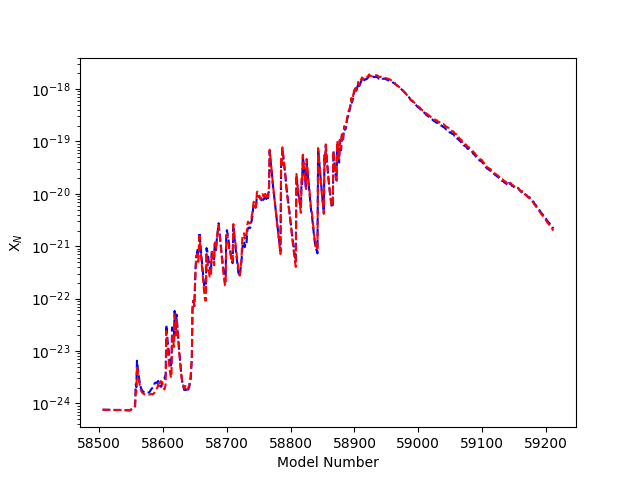

In [12]:
# make plot of the average neutron densities
plt.figure(1)

plt.semilogy(models,avg_iso_massfM[0],'b--')
plt.semilogy(models,avg_iso_massfJ[0],'r--')

# labels
plt.xlabel('Model Number')
plt.ylabel(r'X$_{N}$')

# plt.xlim([53700,53800])

<IPython.core.display.Javascript object>


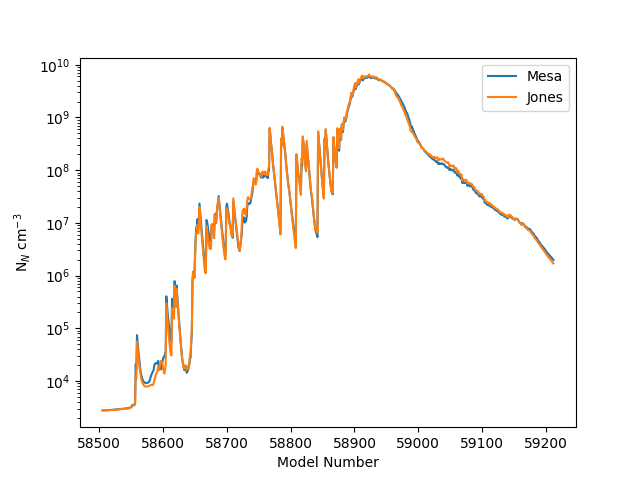

In [17]:
# make a plot of the neutron densities
neutron_mass = 1.674929e-27 * 1e3
neutron_numM = avg_densityM[0] / neutron_mass
neutron_numJ = avg_densityJ[0] / neutron_mass

plt.figure(2)
plt.semilogy(models,neutron_numM,label='Mesa')
plt.semilogy(models,neutron_numJ,label='Jones')

plt.xlabel('Model Number')
plt.ylabel(r'N$_{N}$ cm$^{-3}$')

plt.legend()

<IPython.core.display.Javascript object>


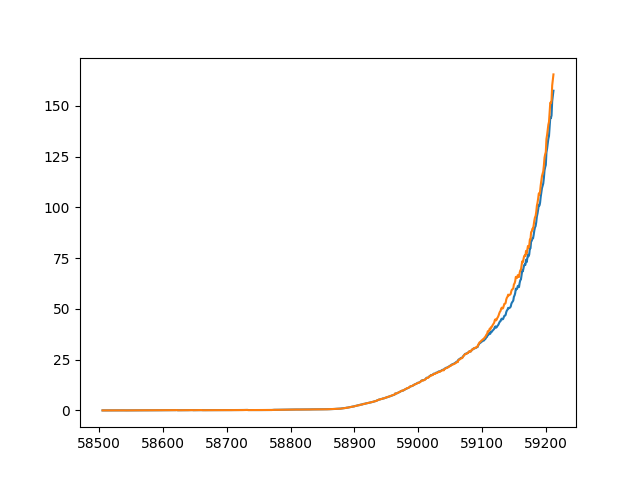

In [14]:
# get absolute mass production of MG 25 relative to the mass BEFORE convection zone
Mg_baseM = avg_densityM[3][0] * avg_volume[0] * (6.95e8 * 1e2)**3
Mg_baseJ = avg_densityJ[3][0] * avg_volume[0] * (6.95e8 * 1e2)**3

# get the magnesium production as a percent difference
Mg_productionM = np.zeros(len(models))
Mg_productionJ = np.zeros(len(models))

for i in range(len(models)):
    Mg_productionM[i] = abs(avg_densityM[3][i] * avg_volume[i] * (6.95e8 * 1e2)**3 - Mg_baseM) / Mg_baseM
    Mg_productionJ[i] = abs(avg_densityJ[3][i] * avg_volume[i] * (6.95e8 * 1e2)**3 - Mg_baseJ) / Mg_baseJ
    
# make a plot of the Mg production
plt.figure(3)

plt.plot(models,Mg_productionM)
plt.plot(models,Mg_productionJ)

## Zr Ratios

In [10]:
# should use the model number after convection
Zr_ratioM = Zr_mil(avg_iso_massfM[2][len(models) -1],avg_iso_massfM[1][len(models) -1])
Zr_ratioJ = Zr_mil(avg_iso_massfJ[2][len(models) -1],avg_iso_massfJ[1][len(models) -1])

# print their values
print(Zr_ratioM)
print(Zr_ratioJ)

-44.1166167927
-53.5384040163
